# Question 1
_Bootstrap with Least squares, Ridge and Lasso._ Let $\beta = (\beta_1, \beta_2, \cdots , \beta_p)$ and let $\pmb x, y$ be random variables such that the entries of $\pmb x$ are i.i.d. standard normal random variables (i.e., with mean zero and variance $1$) and $y = \beta^T \pmb x + \epsilon$ where $\epsilon \sim \mathcal N(0, 1)$.
\begin{enumerate}
\item Simulate a dataset $(\pmb x_1, y_1), \cdots, (\pmb x_n, y_n)$ as $n$ i.i.d. copies of the random variables $\pmb x, y$ defined above, with $n = 800, p = 200$ and $\beta_j = j^{−1}$:
\item The goal of this problem is to construct confidence intervals for $\beta_1$ using Bootstrap method.
\begin{enumerate}[label=(\alph*)]
\item Construct confidence intervals for $\beta_1$ by bootstrapping the data and applying Least Squares to the bootstrapped dataset.
\item Construct confidence intervals for $\beta_1$ by bootstrapping the data and applying Ridge to the bootstrapped data set.
\item Construct confidence intervals for $\beta_1$ by bootstrapping the data and applying Lasso to the bootstrapped data set.
\end{enumerate}\end{enumerate}

First we initialize the above $n,p,\beta$ as given in the above problem.

In [1]:
n = 800
p = 200
b = 1/(1:p)

Now let's generate data:

In [2]:
x = c()
for(i in 1:n){
    x = rbind(x,rnorm(p))
}
y = x %*% b + rnorm(n)

We now bootstrap, to get confidence intervals for $\beta_1$. We sample $B$ datapoints from the above population.

**Least squares:** The estimated $\hat{\pmb\beta} = \left(\hat\beta_1,\cdots,\hat\beta_p\right)$ is given by $M=\left(X^\top X\right)^{-1}X^\top Y$. We note that $\hat\beta_1$ is just the first entry of $M$. But this is just $M_1=\left[\left(X^\top X\right)^{-1}X^\top Y\right]_1 = \left[\left(X^\top X\right)^{-1}X^\top \right]_{1:}\cdot Y = \left[\left(X^\top X\right)^{-1}\right]_{1:}  \cdot X^\top \cdot Y$. Here $A_{i:}$ denotes the $i^{\text{th}}$ row of $A$. 

In [81]:
library(Matrix)
library(glmnet)
B = 500
b1.hat_ls = c()
b1.hat_lasso = c()
b1.hat_ridge = c()
lasso.lambda = c()
ridge.lambda = c()
for(i in 1:B){
    index = sample.int(n, n, replace = TRUE)
    x.hat = x[index,]
    y.hat = y[index]

    #use least squares to estimate beta
    M = t(x.hat) %*% x.hat
    M = solve(M)[1,] %*% t(x.hat)
    M = M %*% y.hat
    b1.hat_ls = append(b1.hat_ls, M)

    best_lambda = cv.glmnet(x.hat, y.hat,family = 'gaussian', alpha = 0)$lambda.min
    ridge.lambda = append(ridge.lambda, best_lambda)
    b1.hat_ridge = append(b1.hat_ridge, glmnet(x.hat, y.hat,family = 'gaussian', alpha = 0, lambda = best_lambda)$beta[1,1])

    best_lambda = cv.glmnet(x.hat, y.hat,family = 'gaussian', alpha = 1)$lambda.min
    lasso.lambda = append(lasso.lambda, best_lambda)
    b1.hat_lasso = append(b1.hat_lasso, glmnet(x.hat, y.hat,family = 'gaussian', alpha = 1, lambda = best_lambda)$beta[1,1])
}
b1.hat_ls = sort(b1.hat_ls)
b1.hat_lasso = sort(b1.hat_lasso)
b1.hat_ridge = sort(b1.hat_ridge)

Now that we have the (sorted) bootstrapped data, we want to find the confidence intervals. Recall that $(1-\alpha)^{\text{th}}\cdot 100\%$ interval for $\beta_1$ is $\left[\hat\theta_{[L]}^*,\hat\theta_{[U]}^*\right]$ where $L=\frac{\alpha B}{2}, U=\left(1-\frac{\alpha}{2}\right)B$ and $\hat\theta_i^*$ are the sorted bootstrapped data.

In [92]:
cat("Average lambda for lasso:\t", mean(lasso.lambda),"\n")
cat("Average lambda for ridge:\t", mean(ridge.lambda),"\n")
a = 0.05
L = floor(a * B / 2)
U = floor((1 - a / 2) * B)
cat("Interval for Least squares:\t(",b1.hat_ls[max(L,1)], ",",b1.hat_ls[U],")\n")
cat("Interval for Lasso:\t\t(",b1.hat_lasso[max(L,1)], ",",b1.hat_lasso[U],")\n")
cat("Interval for Ridge:\t\t(",b1.hat_ridge[max(L,1)], ",",b1.hat_ridge[U],")\n")

Average lambda for lasso:	 0.02391449 
Average lambda for ridge:	 0.2103526 
Interval for Least squares:	( 0.9796613 , 1.152104 )
Interval for Lasso:		( 0.9557822 , 1.101985 )
Interval for Ridge:		( 0.8088076 , 0.9775276 )


Notice that beacuse the ridge method includes all predictors which makes the average minimum $\lambda$ in this case is quite higher than the average minimum $\lambda$ for the lasso case, which actually makes some parameters $0$ due to the polyhedral nature of the $L^1$ ball (thus leading to variable selection). This affects the model and as a result, the actual $\beta_1$ is not in the confidence interval for ridge. The high bias in the ridge method leads to underestimating the parameter values.

\newpage
# Question 2
This problem uses the data set $\texttt{mer}$. The data set contains monthly excess returns (including dividends) of ten stocks: A.G. Edwards, Citigroup, Morgan Stanley, Merrill Lynch, Dell, HP, IBM, Alcoa, Caterpillar, and P\&G. We use the monthly series of 3-month Treasury bill rates of the secondary market as the risk-free interest rate to obtain simple excess returns. The sample span is from January $1990$ to December $2006$.
Analyze this data using PCA.
\begin{enumerate}[label=(\alph*)]
\item Plot the variances against the principal components. You may also want to plot the proportions of variabilities explained by the principal components, as well as the cumulative proportions. Comment
on the plots.
\item Report the loadings for a few important principal components, and provide some interpretations.
\end{enumerate}

In [76]:
library(ggplot2)
library(factoextra)
X <- as.matrix(read.table("./mer.txt", header = TRUE))
pca <- prcomp(X, center = TRUE, retx = T)

Here is a summary consisting of standard deviations, proportions of variance and cumulative proportions.

In [72]:
summary(pca)

Importance of components:
                           PC1     PC2     PC3     PC4     PC5     PC6     PC7
Standard deviation     21.0096 13.5896 9.96647 8.48400 7.17104 6.46254 5.94712
Proportion of Variance  0.4432  0.1854 0.09973 0.07227 0.05163 0.04193 0.03551
Cumulative Proportion   0.4432  0.6286 0.72834 0.80060 0.85224 0.89417 0.92968
                           PC8     PC9   PC10
Standard deviation     5.05808 5.01311 4.3957
Proportion of Variance 0.02569 0.02523 0.0194
Cumulative Proportion  0.95537 0.98060 1.0000

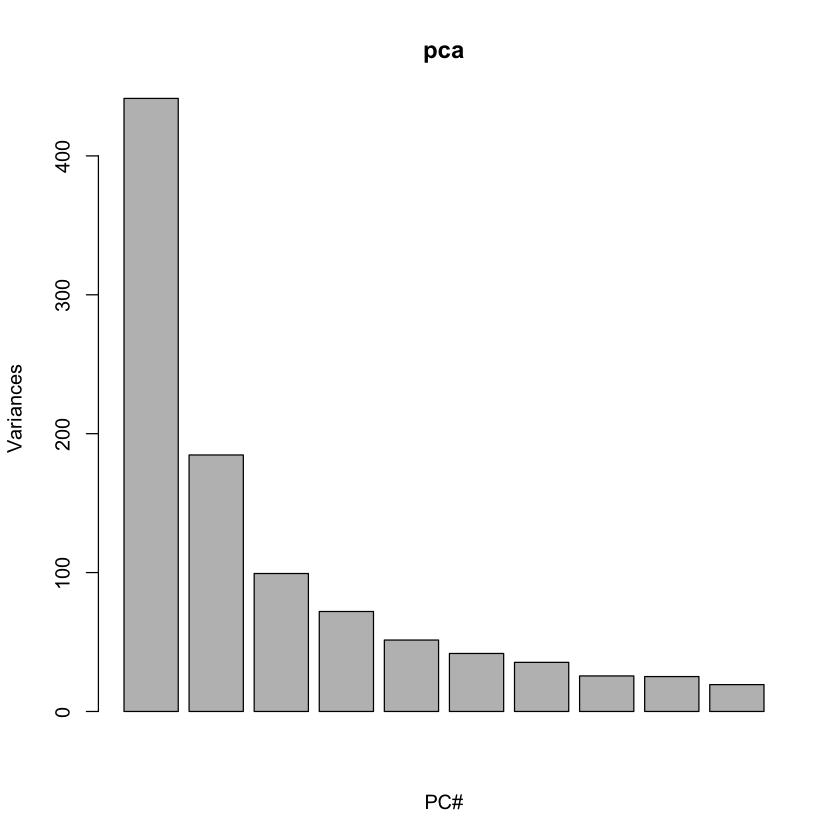

In [103]:
plot(pca, xlab="PC#")

And here is a plot for the proportion of variance and cumulative variance. (Note that the plot for proportion of variance and the plot for variances look the same because the former is just the normalized version of the latter). 

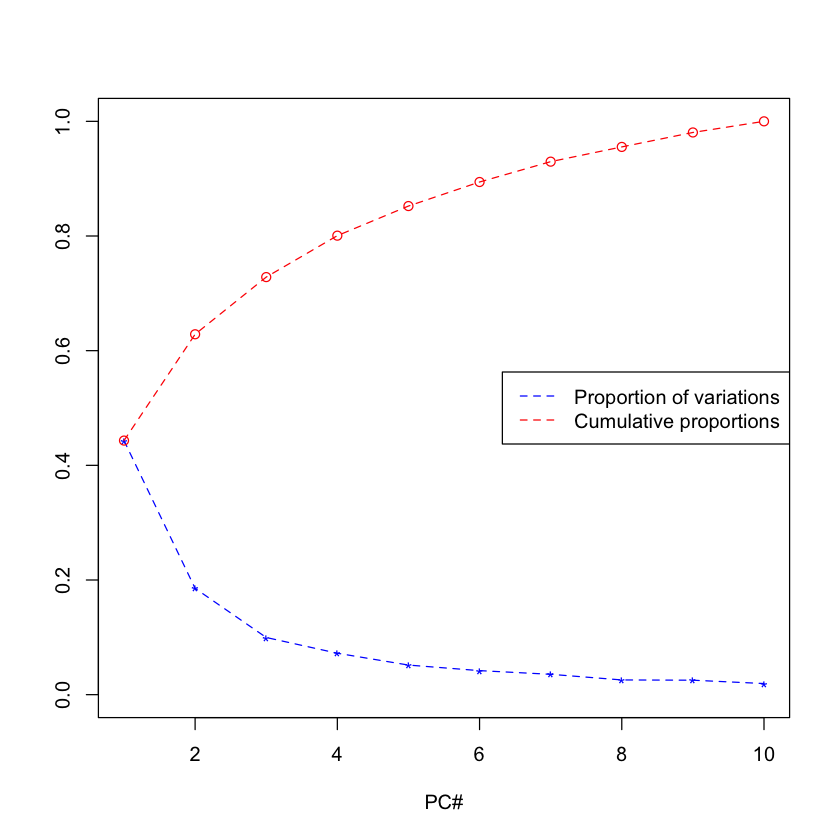

In [75]:
plot(pca$sdev^2 / sum(pca$sdev^2), ylim=c(0,1), type='o', lty=2, pch = "*", col="blue",xlab="PC#",ylab="")
points(cumsum(pca$sdev^2 / sum(pca$sdev^2)),type='o',lty = 2, col="red")
legend("right", legend=c("Proportion of variations","Cumulative proportions"), col=c("blue","red"), lty=c(2,2), cex=1)

Here's the matrix comprising of the eigenvectors corresponding to each principal component, in decreasing order of variances.

In [102]:
print(pca$rotation)

            PC1         PC2        PC3         PC4         PC5         PC6
AGE  0.30393776  0.23278636  0.3037223  0.21171911  0.07448142 -0.67971942
C    0.30115193  0.26879351  0.1446771  0.16672408  0.11152086  0.21897310
MWD  0.37911317  0.33805005  0.2102347 -0.10520037 -0.01102813  0.18386264
MER  0.34512971  0.32357098  0.2017055 -0.13177442 -0.10689871  0.07476144
DELL 0.49372430 -0.79274875  0.2768454  0.17997778 -0.05221714  0.05053384
HPQ  0.37378394 -0.06820231 -0.3606515 -0.71772038 -0.24332481 -0.11624552
IBM  0.25316632 -0.02936748 -0.3036086 -0.06048848  0.86224995  0.16759741
AA   0.26670608  0.02414793 -0.5191519  0.25634077 -0.28163363 -0.13316030
CAT  0.17297839  0.12087435 -0.4673489  0.52352696 -0.12791597  0.06288182
PG   0.07391264  0.07366293  0.1229344  0.08934206 -0.26339722  0.62031942
             PC7         PC8          PC9         PC10
AGE  -0.36750927 -0.06620430  0.322507431 -0.073055231
C    -0.18177279  0.76491349 -0.313705621  0.106760712
MWD   0.44

From the summary above we note that the first four components (instead of ten!) capture an enormous $80\%$ of the variance. This means that we can try to analyze the data using only the first four principal components. We could also keep only the first two components if we felt that it is enough to capture $63\%$ of the variance, which makes the data low dimensional and easier to work with. Here's the first four loadings:

In [101]:
print(pca$rotation[,1:4])

            PC1         PC2        PC3         PC4
AGE  0.30393776  0.23278636  0.3037223  0.21171911
C    0.30115193  0.26879351  0.1446771  0.16672408
MWD  0.37911317  0.33805005  0.2102347 -0.10520037
MER  0.34512971  0.32357098  0.2017055 -0.13177442
DELL 0.49372430 -0.79274875  0.2768454  0.17997778
HPQ  0.37378394 -0.06820231 -0.3606515 -0.71772038
IBM  0.25316632 -0.02936748 -0.3036086 -0.06048848
AA   0.26670608  0.02414793 -0.5191519  0.25634077
CAT  0.17297839  0.12087435 -0.4673489  0.52352696
PG   0.07391264  0.07366293  0.1229344  0.08934206


Observe that the first component has substantial positive loadings AG Edwards, Citygroup, Morgan Stanley, Merrill Lynch, Dell and HP. It also has some positive loadings (lower) for IBM, Alcoa, Caterpillar and P\&G. This is the component that impacts the returns of all companies in the dataset.

The second component has significant positive loadings for Morgan Stanley and Merrill Lynch, somewhat for AG Edwards, Citygroup and Catterpillar, and quite low but positive loadings for Alcoa and P\&G.

Another (least) important component is the tenth component. It has the feature that the loading for Merrill Lynch is quite high. So returns associated with Merrill Lynch don't affect the variance of the data much. In other words, variance for the Merrill Lynch returns might be low.